<a href="https://colab.research.google.com/github/Bayesian-Logic/waveforms/blob/main/notebooks/segment_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook trains a Deep Learning model to learn the arrival time of waveforms.

In [1]:
# @title Default title text
EXPERIMENT = "exp006" # @param {type:"string"}
NOTES = "2021 pos wt 2" # @param {type:"string"}
DEBUG_RUN = False # @param {type:"boolean"}
DISABLE_WANDB = False # @param {type:"boolean"}
# @markdown Checking TRAIN_FULL will result in a model that trains on the entire dataset.
# @markdown Only do this for final testing.
TRAIN_FULL = False # @param {type:"boolean"}
TRAIN_FILE = "cb-100-2021001-2022001.parquet" # @param ["cb-100-2021001-2021010.parquet", "cb-100-2021001-2022001.parquet"] {allow-input: true}
TEST_FILE = "cb-100-2022001-2022010.parquet" # @param ["cb-100-2022001-2022010.parquet", "cb-100-2022001-2023001.parquet"] {allow-input: true}

DATA_DIR = "/content/data"
OUTPUT_DIR="/content/output"
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [2]:
# @title CONFIG OPTIONS
import yaml, os

CONFIG = yaml.safe_load(f"""
exp_name: {EXPERIMENT}
notes: {NOTES}
disable_wandb: {DISABLE_WANDB}
output_dir: {OUTPUT_DIR}
data_dir: {DATA_DIR}

model:
  pos_weight: 2
  class_name: UNetEncoder
  UNetEncoder:
    max_len: 1200
    d_model: 256
    n_heads: 8
    n_layers: 6
    n_classes: 1
    n_features: 1
    dropout_prob: 0.1
    kernel_size: 7
    feedforward_mult: 3

train:
  fold_idx: 0
  num_folds: 5
  samprate: 20 # we will resample to this rate
  data_window: 100 # LEB arrivals are centered in the data_window in each datum
  train_window: 60 # a random subset of size train_window is selected from each datum

  # We construct a Gaussian target of the given sigma and length seconds
  target_sigma: 0.3
  target_length: 1

  batch_size: 32
  seed: 42
  epoch: 10
  num_workers: 2
  accelerator: auto
  use_amp: true
  debug: {DEBUG_RUN}
  gradient_clip_val: 1.0
  accumulate_grad_batches: 1
  check_val_every_n_epoch: 1
  train_full: {TRAIN_FULL}
  deterministic: true
  train_file: {TRAIN_FILE}
  test_file: {TEST_FILE}

optimizer:
  lr: 0.0005
  class_name: AdamW  # SGD or AdamW
  SGD:
    momentum: 0.9
    weight_decay: 0
    nesterov: false
    dampening: 0
  AdamW:
    weight_decay: 0
  scheduler: cosine
  num_warmup_steps: 0
""")

# Setup

In [3]:
# @title Create a logger for Colab.
import logging
from datetime import datetime

# Create a root logger with the level set to INFO
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Remove all existing handlers
for handler in logger.handlers[:]:  # Iterate over a copy of the list to avoid modification during iteration
    handler.close()
    logger.removeHandler(handler)


# Create a formatter with timestamp
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

# Create a custom handler to capture logs and display them in the output cell
class ColabHandler(logging.Handler):
    def emit(self, record):
        log_entry = self.format(record)
        print(log_entry)

# Add the custom handler to the logger
ch = ColabHandler()
ch.setFormatter(formatter)
logger.addHandler(ch)

info = logging.getLogger().info

info("Logger created.")

2024-01-19 01:47:49 - INFO - root - Logger created.


In [4]:
# @title Clone the github repository
from google.colab import userdata
GITHUB_TOKEN = userdata.get('GITHUB_WAVEFORMS_TOKEN')
REPO = "waveforms"
REPO_URL = f"https://{GITHUB_TOKEN}@github.com/Bayesian-Logic/{REPO}.git"
import os
if not os.path.exists(REPO):
  info("Cloning github repository.")
  !git clone $REPO_URL
  # configuring user name and email to allow us to make changes
  !git config  --global user.email "nimar.arora@gmail.com"
  !git config  --global user.name "Nimar Arora"
  !git config  --global pull.rebase true
else:
  info("Github repository already exists.")
import sys
repo_path = f"/content/{REPO}/src"
if sys.path[1] != repo_path:
  sys.path.insert(1, repo_path)
# it's handy to use the autoreload extension in case we need to change some code
# but if not changing code then you could remove these two lines.
%load_ext autoreload
%autoreload 2


2024-01-19 01:47:50 - INFO - root - Cloning github repository.
Cloning into 'waveforms'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 125 (delta 38), reused 100 (delta 23), pack-reused 0
Receiving objects: 100% (125/125), 12.98 MiB | 8.75 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [5]:
# @title Download data
import os
import json
import concurrent.futures
from google.colab import userdata
from google.oauth2 import service_account
from google.cloud import storage

# Set up data directory
os.environ['DATA_DIR'] = '/content/data'

def download_file(filename):
    account_info = json.loads(userdata.get('GCP_SERVICE_ACCOUNT'))
    credentials = service_account.Credentials.from_service_account_info(account_info)
    storage_client = storage.Client(credentials=credentials)

    bucket = storage_client.bucket('segment-waveforms')
    blob = bucket.blob(filename)
    blob.download_to_filename(os.path.join(DATA_DIR, filename))

if not os.path.exists(DATA_DIR):
    info("Downloading data.")
    !mkdir -p $DATA_DIR

    download_file(TRAIN_FILE)
    download_file(TEST_FILE)

    info("Finished downloading data.")

else:
    info("Data already downloaded.")

2024-01-19 01:47:54 - INFO - root - Downloading data.
2024-01-19 01:48:25 - INFO - root - Finished downloading data.


In [6]:
# @title Login to wandb
!pip -q install wandb
from google.colab import userdata
import os
os.environ["WANDB_API_KEY"] = userdata.get('WANDB_API_KEY')
os.environ["WANDB_ENTITY"] = userdata.get("WANDB_ENTITY")
os.environ["WANDB_PROJECT"] = "segment-waveforms"
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


wandb: Currently logged in as: nimar-arora. Use `wandb login --relogin` to force relogin


True

In [7]:
# @title Install some needed external packages
!pip -q install torch torchinfo pytorch_lightning transformers scikit-image
import torch, torchinfo, pytorch_lightning, transformers, skimage
info("torch: %s" % torch.__version__)
info("torchinfo: %s" % torchinfo.__version__)
info("pytorch_lightning: %s" % pytorch_lightning.__version__)
info("transformers: %s" % transformers.__version__)
info("skimage: %s" % skimage.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 16.6 MB/s eta 0:00:00
2024-01-19 01:49:05 - INFO - root - torch: 2.1.0+cu121
2024-01-19 01:49:05 - INFO - root - torchinfo: 1.8.0
2024-01-19 01:49:05 - INFO - root - pytorch_lightning: 2.1.3
2024-01-19 01:49:05 - INFO - root - transformers: 4.35.2
2024-01-19 01:49:05 - INFO - root - skimage: 0.19.3


# Train a model

In [8]:
from seg.utils.train import do_train
data, model = do_train(CONFIG)

2024-01-19 01:49:05 - INFO - numexpr.utils - NumExpr defaulting to 2 threads.
2024-01-19 01:49:06 - INFO - lightning_fabric.utilities.seed - Seed set to 42


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


2024-01-19 01:49:10 - INFO - pytorch_lightning.utilities.rank_zero - Using 16bit Automatic Mixed Precision (AMP)
2024-01-19 01:49:10 - INFO - pytorch_lightning.utilities.rank_zero - Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
2024-01-19 01:49:10 - INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True
2024-01-19 01:49:10 - INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU cores
2024-01-19 01:49:10 - INFO - pytorch_lightning.utilities.rank_zero - IPU available: False, using: 0 IPUs
2024-01-19 01:49:10 - INFO - pytorch_lightning.utilities.rank_zero - HPU available: False, using: 0 HPUs
2024-01-19 01:49:10 - INFO - seg.data - SegDataModule setup stage=<TrainerFn.FITTING: 'fit'>
2024-01-19 01:49:20 - INFO - seg.data - Training fold 0 of 5 folds has 52707 train waveforms and 13203 validati

┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type               ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ model                      │ UNetEncoder        │  5.4 M │
│ 1  │ model.inc                  │ DoubleConv         │  2.0 K │
│ 2  │ model.inc.double_conv      │ Sequential         │  2.0 K │
│ 3  │ model.down1                │ Down               │ 10.9 K │
│ 4  │ model.down1.maxpool_conv   │ Sequential         │ 10.9 K │
│ 5  │ model.down2                │ Down               │ 43.3 K │
│ 6  │ model.down2.maxpool_conv   │ Sequential         │ 43.3 K │
│ 7  │ model.down3                │ Down               │  172 K │
│ 8  │ model.down3.maxpool_conv   │ Sequential         │  172 K │
│ 9  │ model.down4                │ Down               │  689 K │
│ 10 │ model.down4.maxpool_conv   │ Sequential         │  689 K │
│ 11 │ model.pos_encoding         │ PositionalEncoding │      0 │
│ 12 │ model.pos_encoding.dropout │ Dropout            │      0 │
│ 13 │ model.encoder              │ TransformerEncoder │  4.0 M │
│ 14 │ model.encoder.layers       │ ModuleList         │  4.0 M │
│ 15 │ model.ln                   │ LayerNorm          │    512 │
│ 16 │ model.up1                  │ Up                 │  410 K │
│ 17 │ model.up1.up               │ ConvTranspose1d    │ 65.7 K │
│ 18 │ model.up1.conv             │ DoubleConv         │  344 K │
│ 19 │ model.up2                  │ Up                 │  102 K │
│ 20 │ model.up2.up               │ ConvTranspose1d    │ 16.4 K │
│ 21 │ model.up2.conv             │ DoubleConv         │ 86.3 K │
│ 22 │ model.up3                  │ Up                 │ 25.8 K │
│ 23 │ model.up3.up               │ ConvTranspose1d    │  4.1 K │
│ 24 │ model.up3.conv             │ DoubleConv         │ 21.6 K │
│ 25 │ model.up4                  │ Up                 │  6.5 K │
│ 26 │ model.up4.up               │ ConvTranspose1d    │  1.0 K │
│ 27 │ model.up4.conv             │ DoubleConv         │  5.4 K │
│ 28 │ model.outc                 │ OutConv            │     17 │
│ 29 │ model.outc.conv            │ Conv1d             │     17 │
│ 30 │ loss_fn                    │ BCEWithLogitsLoss  │      0 │
└────┴────────────────────────────┴────────────────────┴────────┘

Trainable params: 5.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.4 M                                                                                                
Total estimated model params size (MB): 21

Output()

2024-01-19 02:19:14 - INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=10` 
reached.

# Check on a few validation examples

In [9]:
"""
from seg.data.datamodule import SegDataModule
from seg.utils.common import json_to_py
cfg = json_to_py(CONFIG)
data = SegDataModule(cfg)
data.prepare_data()
data.setup(stage="fit")
"""

'\nfrom seg.data.datamodule import SegDataModule\nfrom seg.utils.common import json_to_py\ncfg = json_to_py(CONFIG)\ndata = SegDataModule(cfg)\ndata.prepare_data()\ndata.setup(stage="fit")\n'

In [10]:
bat = next(iter(data.val_dataloader()))
bat.keys()

dict_keys(['waveform', 'onset', 'name', 'index', 'target'])

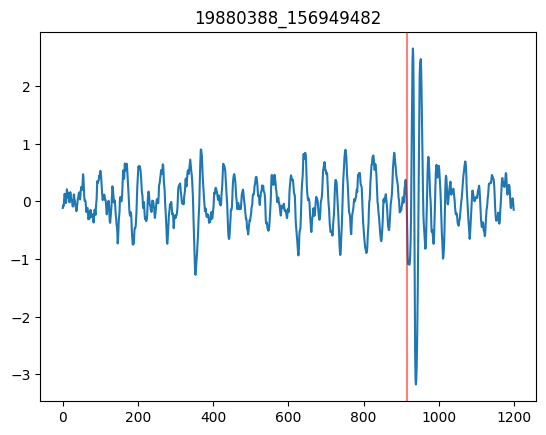

In [11]:
import matplotlib.pyplot as plt
plt.title(bat["name"][0])
plt.plot(bat['waveform'][0].cpu().numpy())
plt.axvline(x=bat["onset"][0], color='red', alpha=.5)

In [12]:
# move the batch to GPU
#bat = {key: (tensor.to('cuda') if key in ['waveform', 'target'] else tensor) for key, tensor in bat.items()}

In [13]:
out = model(bat)
out.keys()

dict_keys(['loss', 'loss_full', 'onset_pred', 'target_pred'])

In [14]:
out["loss_full"].shape, out["loss"].shape, out["target_pred"].shape, out["onset_pred"].shape

((32,), torch.Size([]), (32, 1200), (32,))

## Print the waveforms using Matplotlib

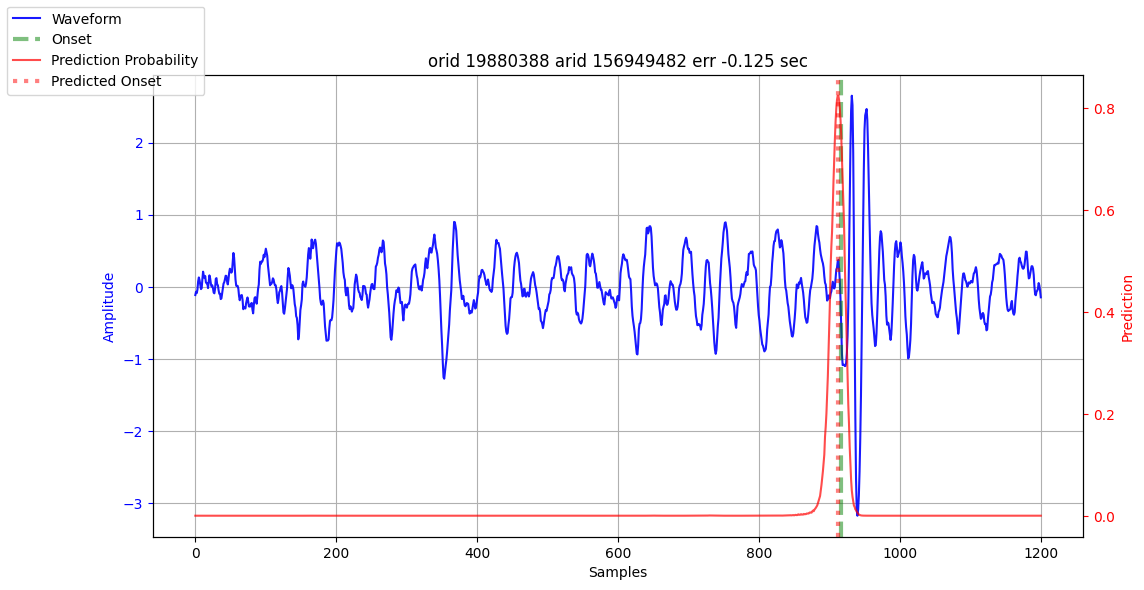

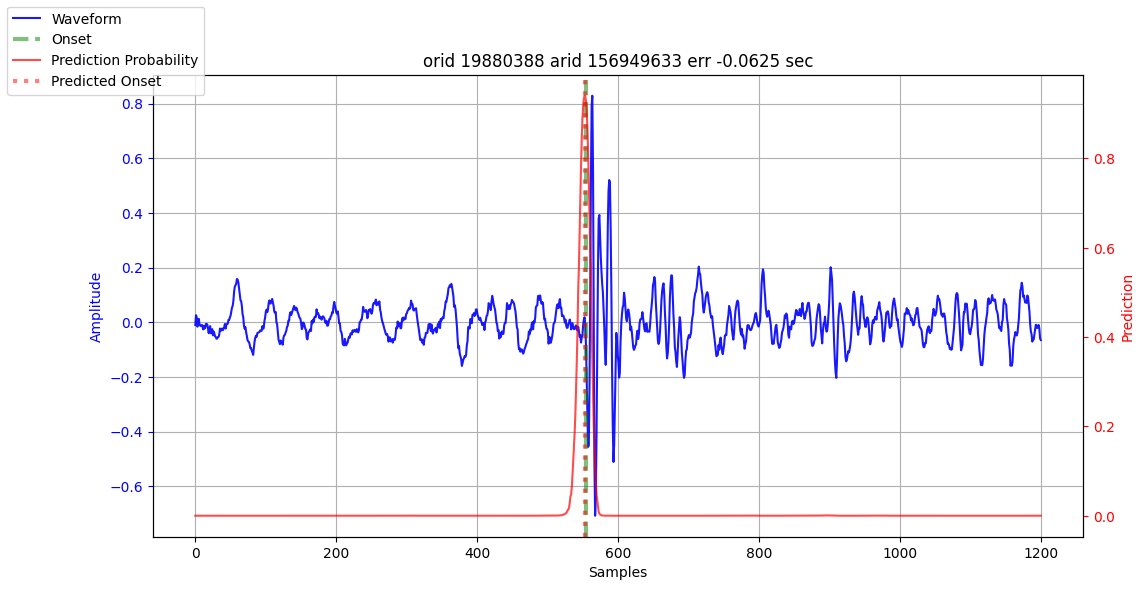

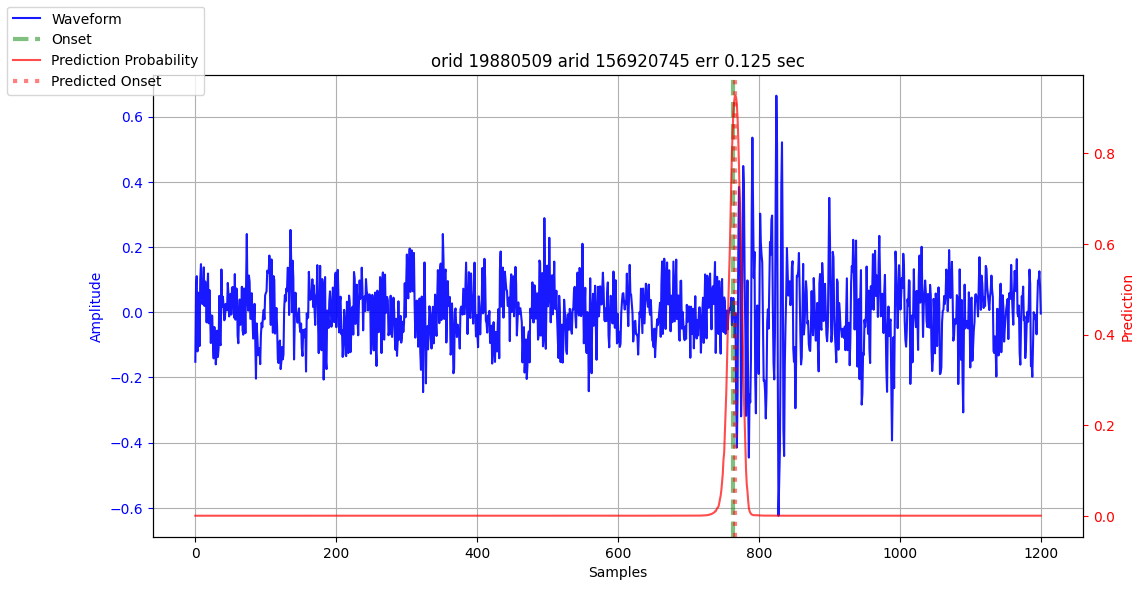

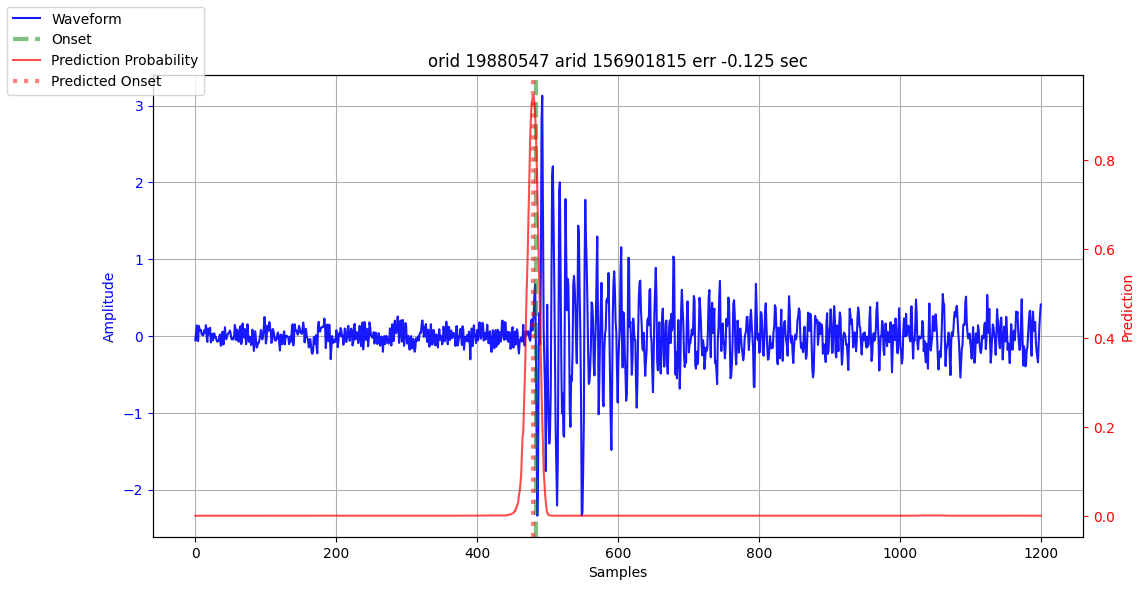

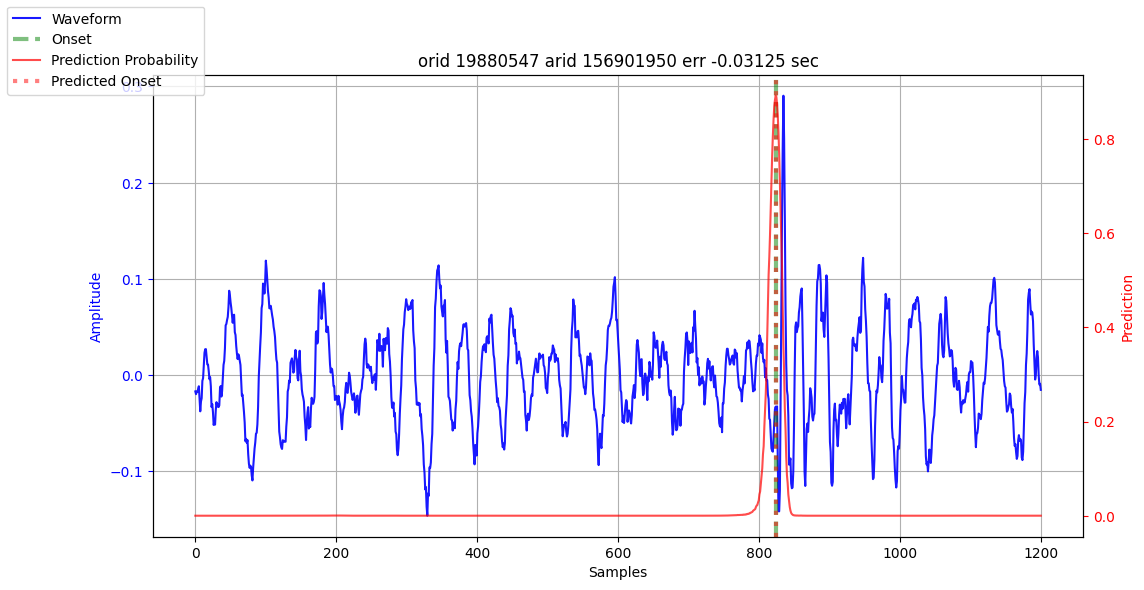

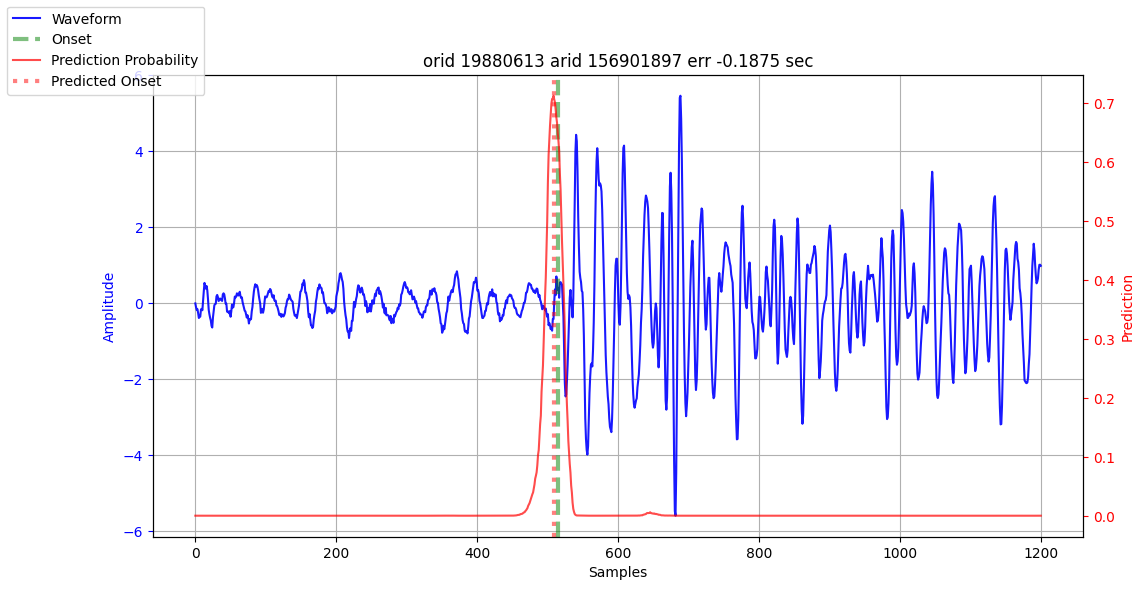

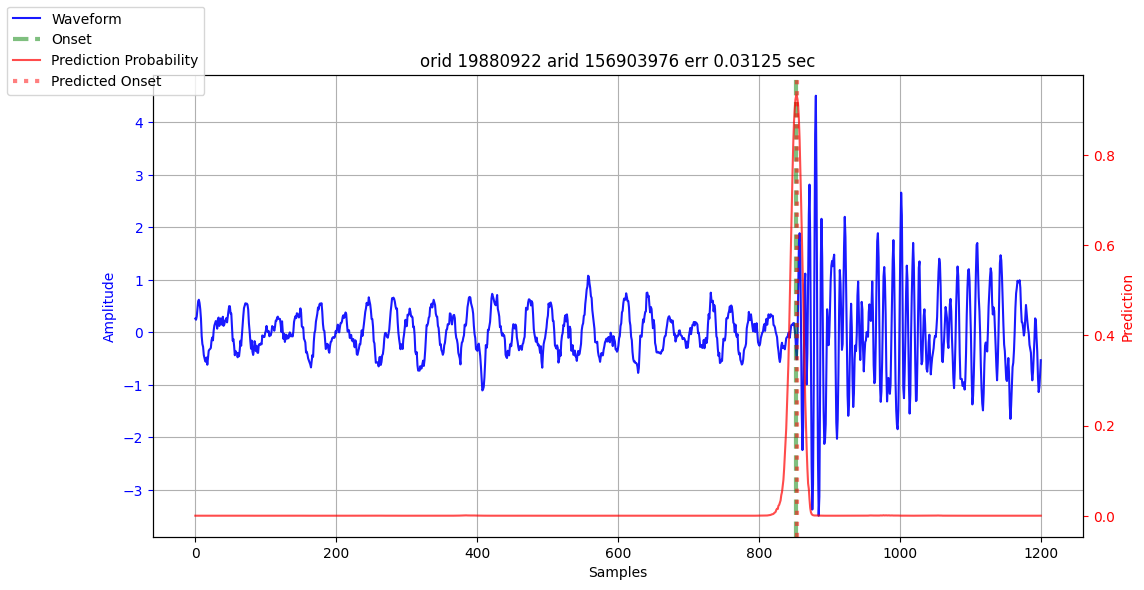

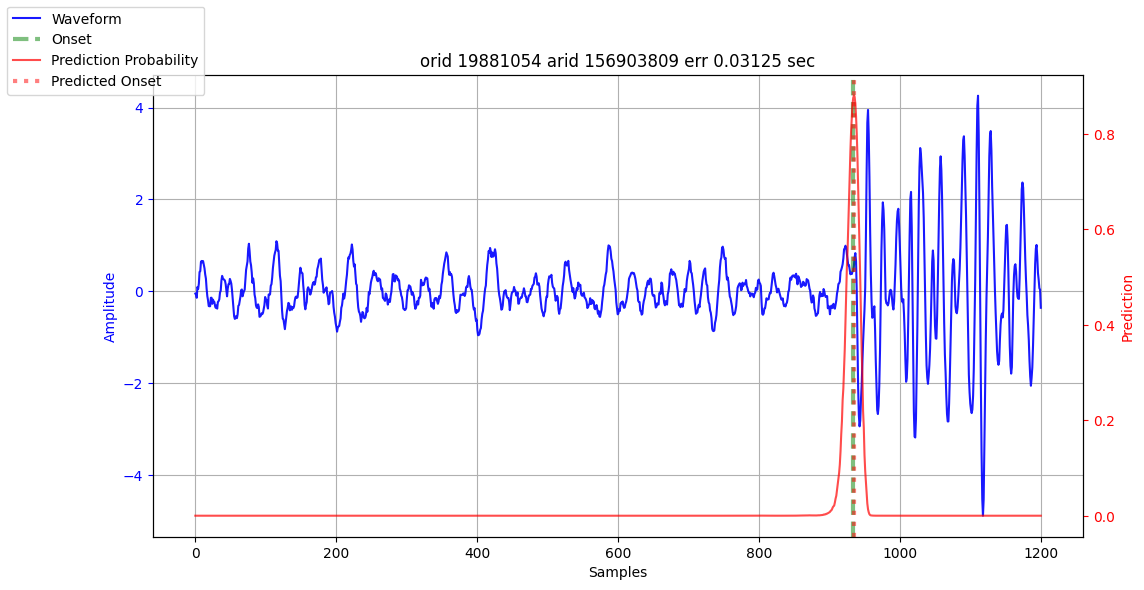

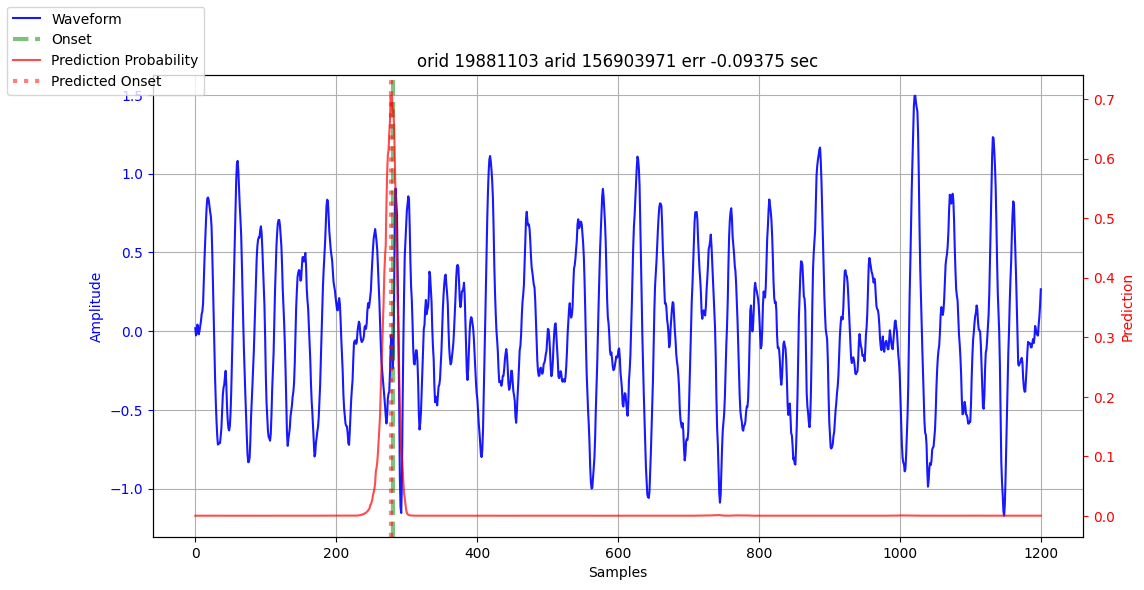

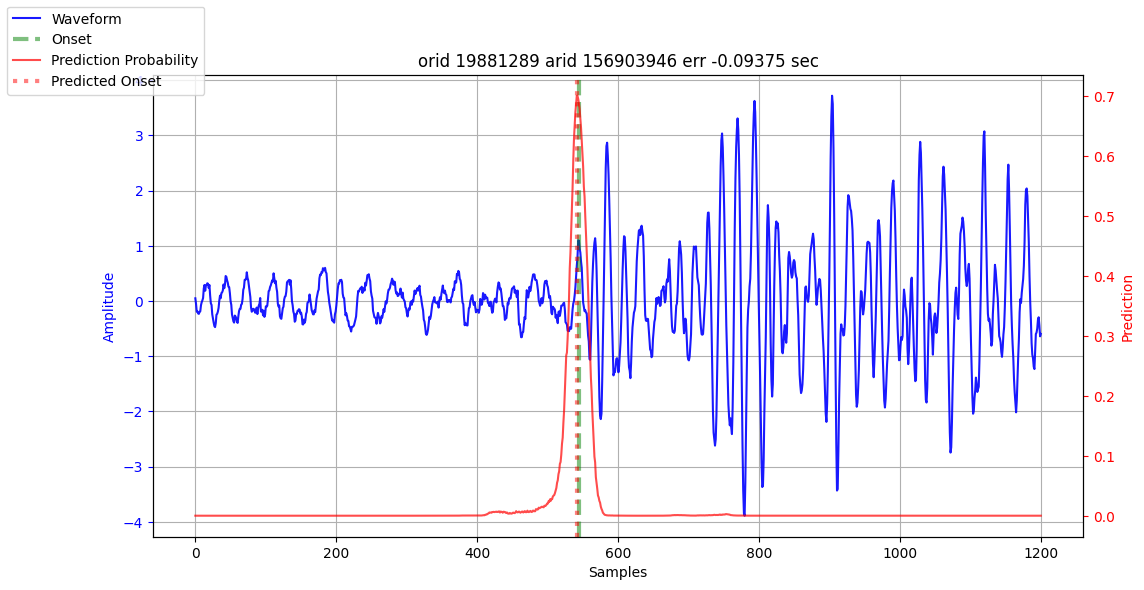

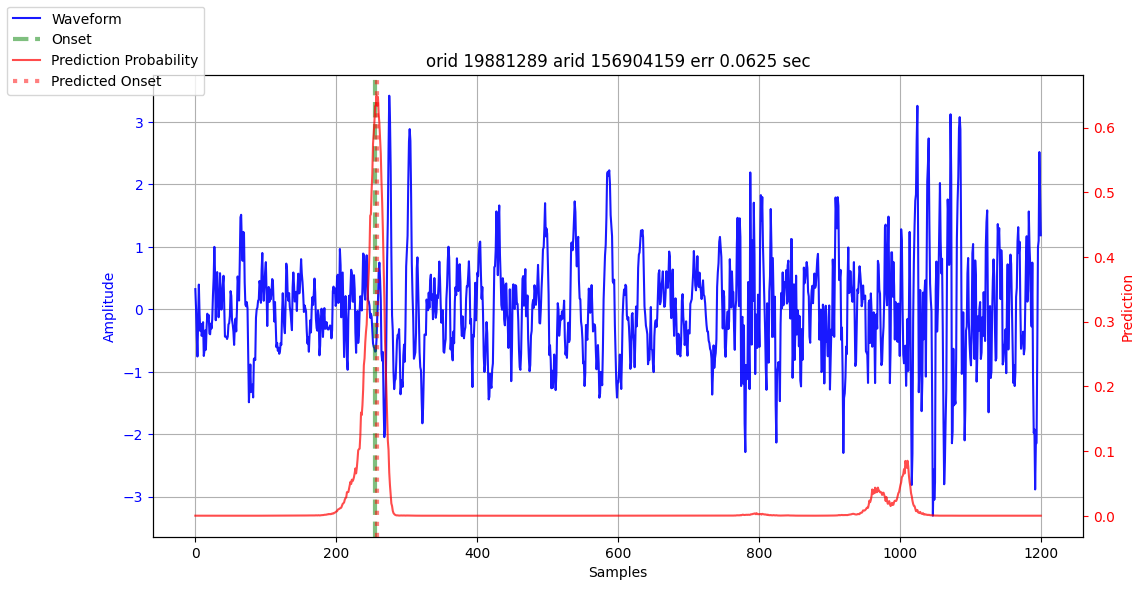

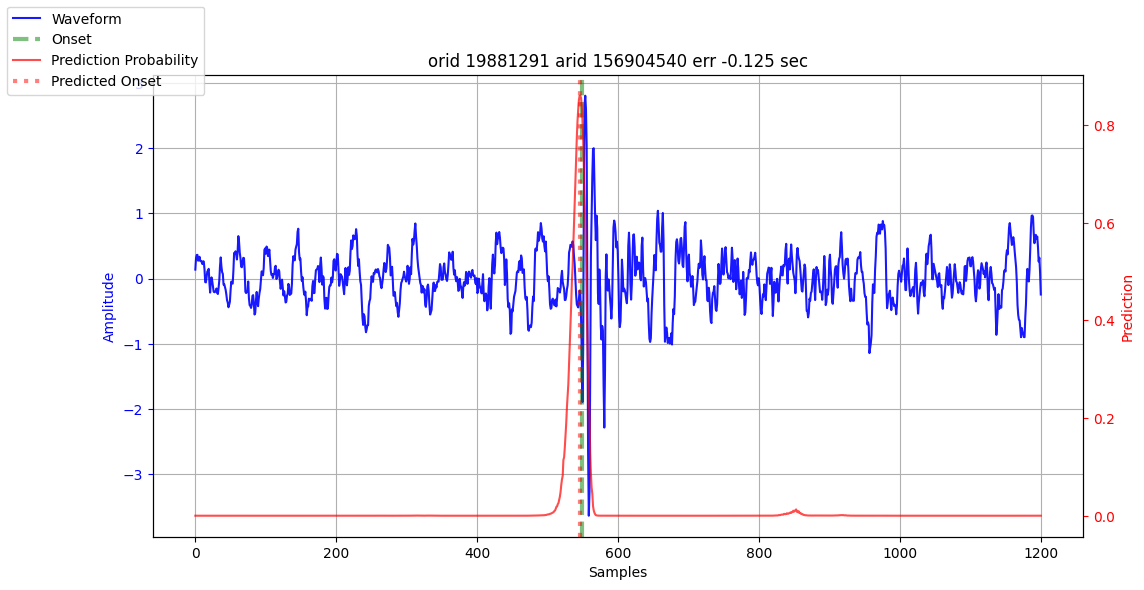

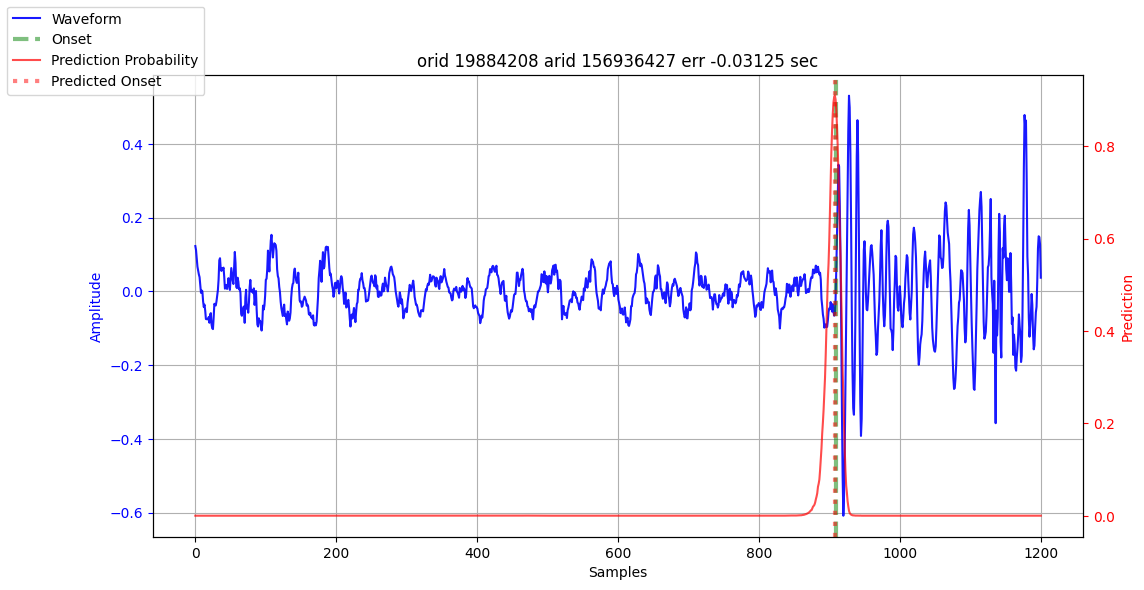

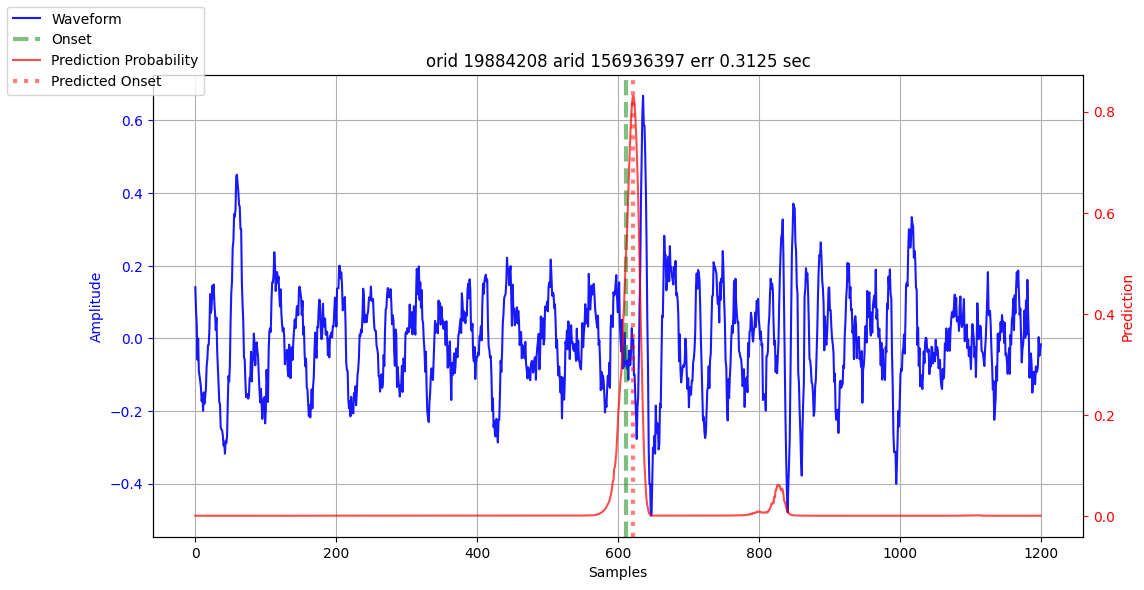

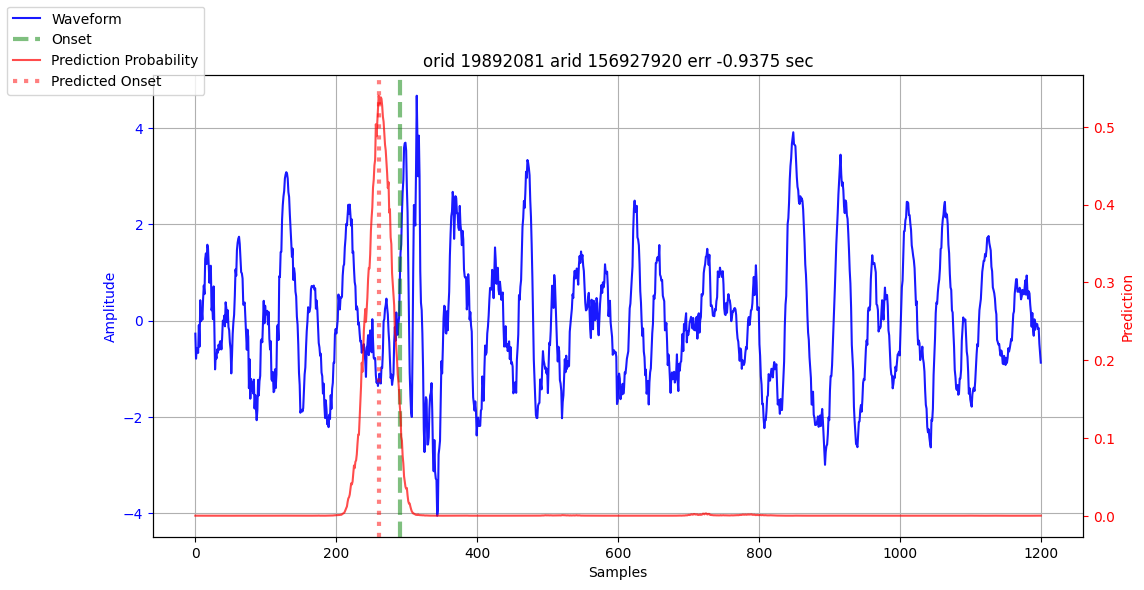

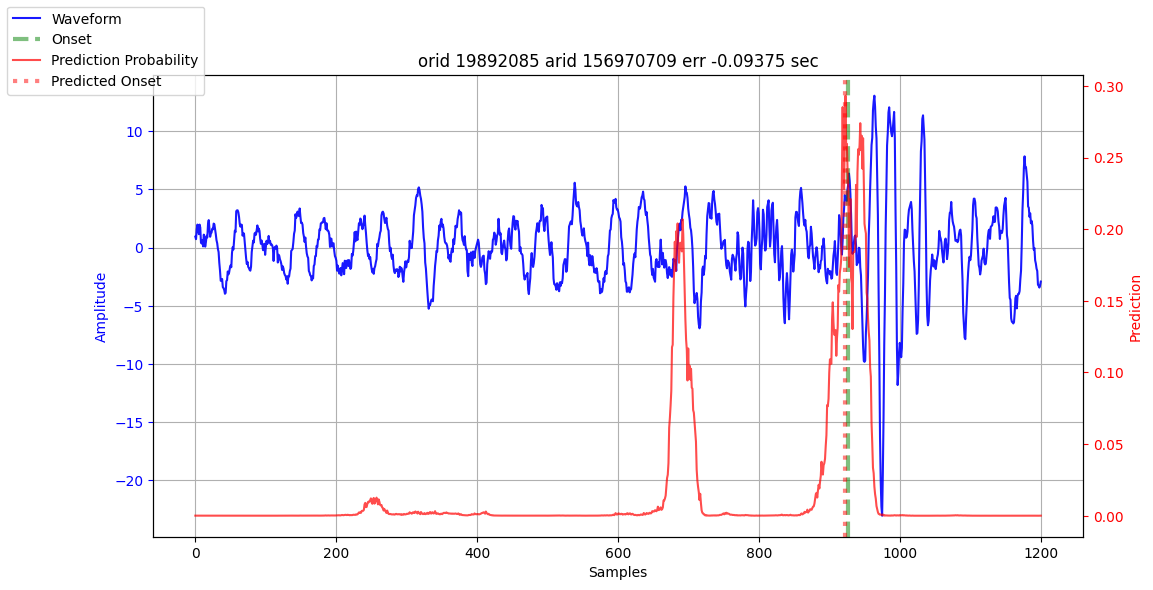

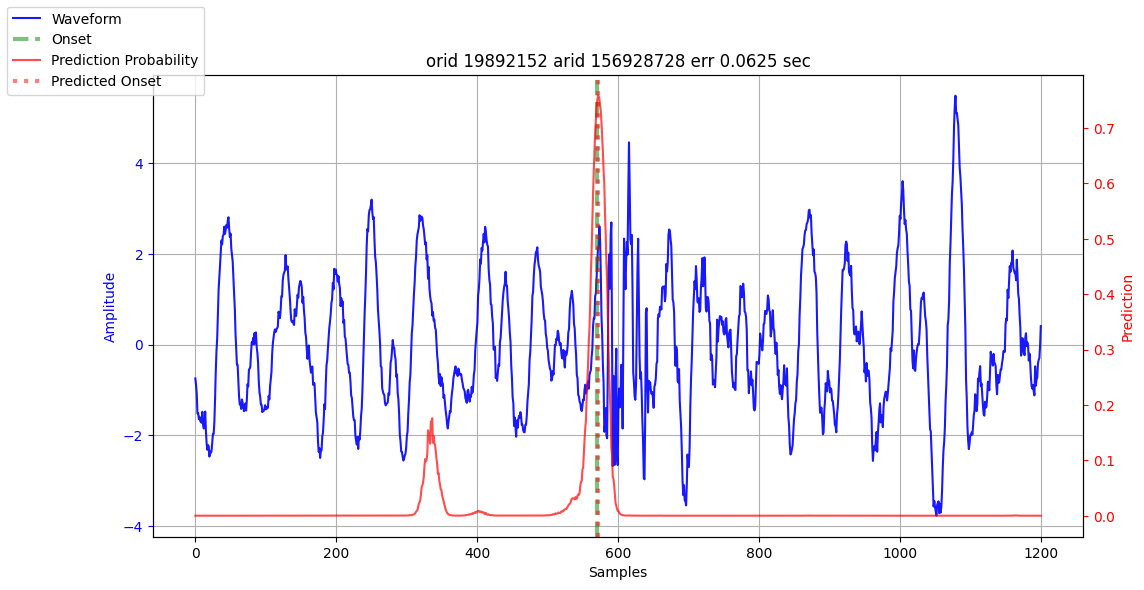

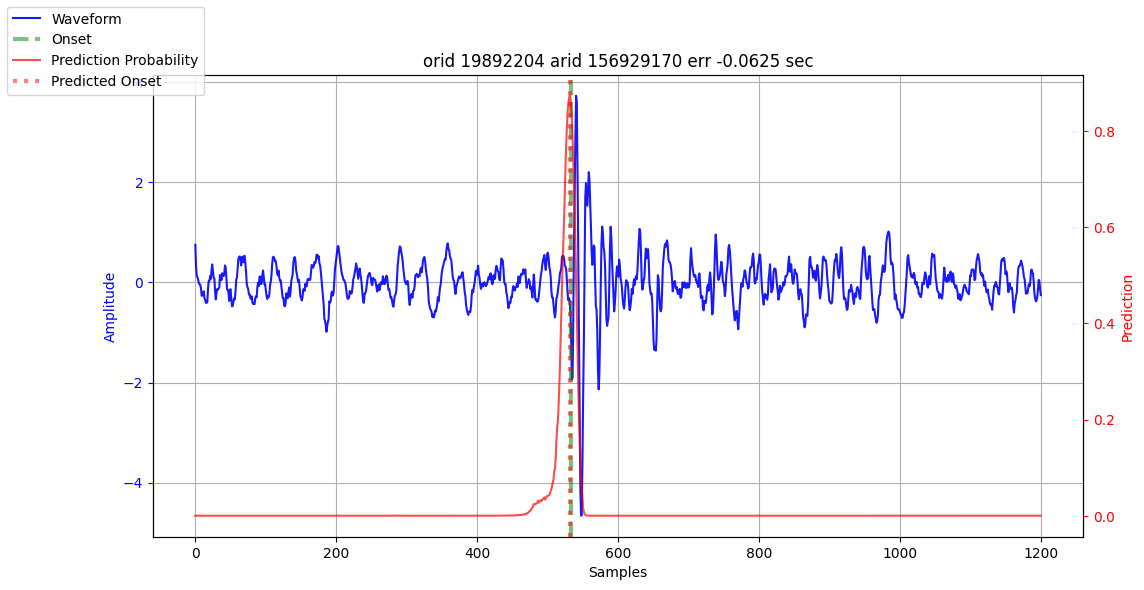

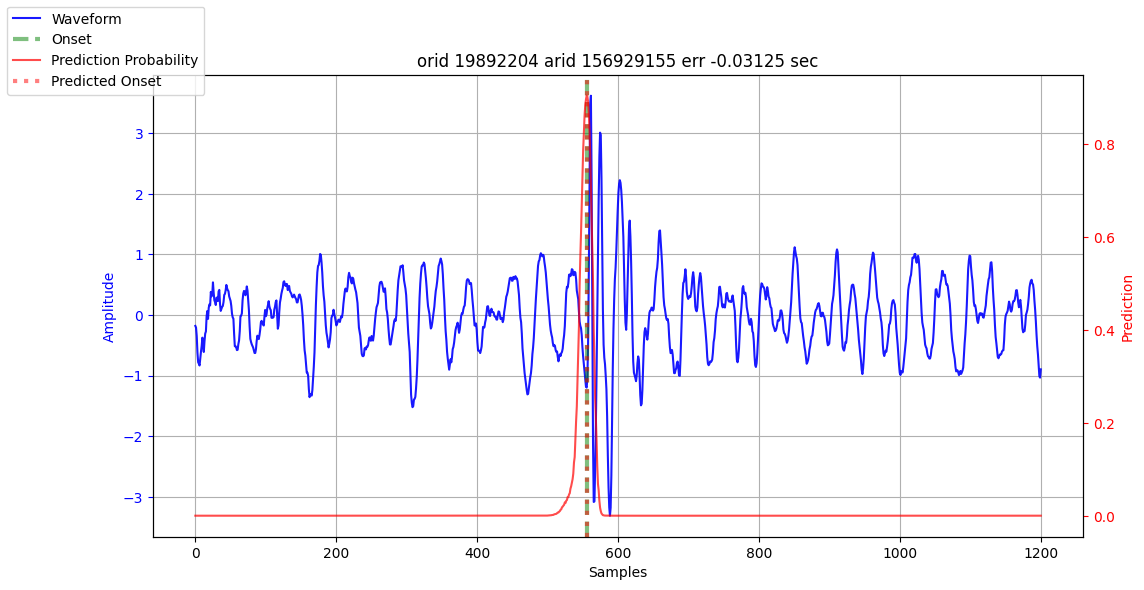

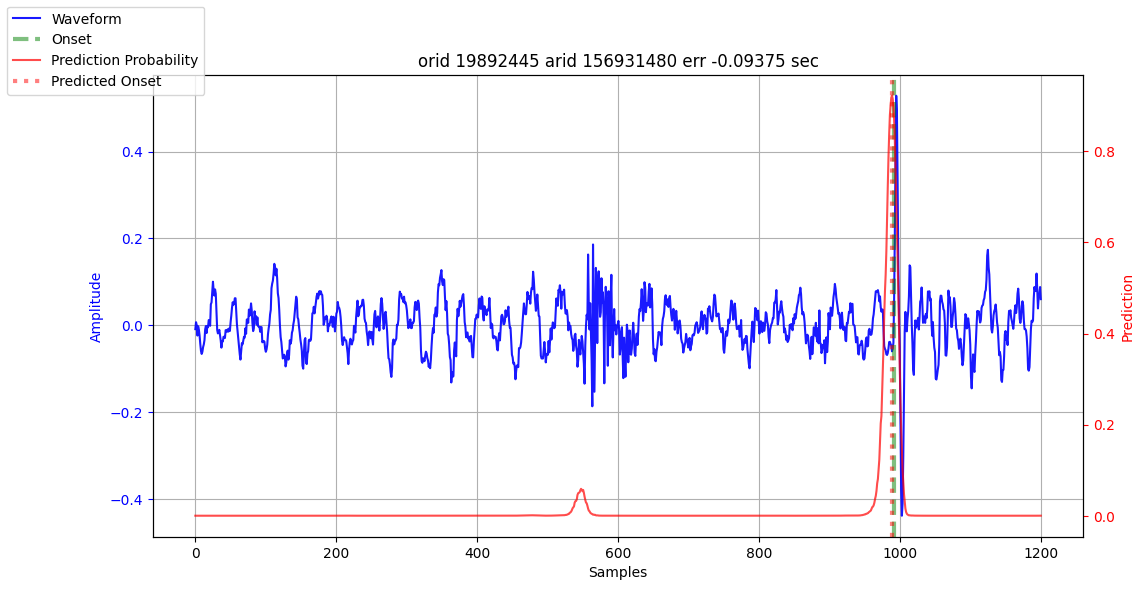

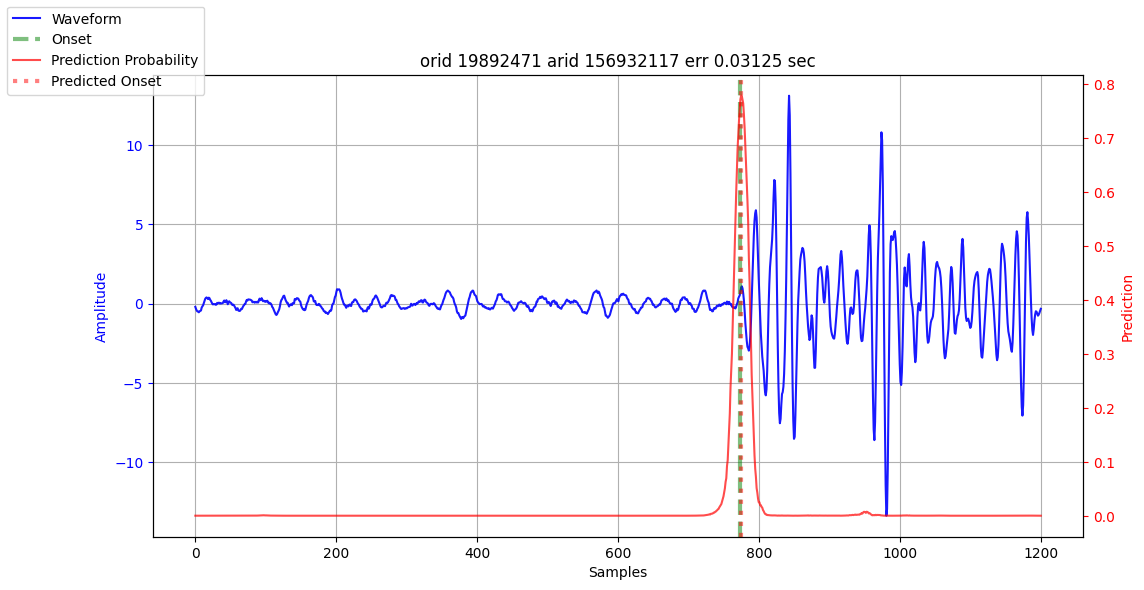

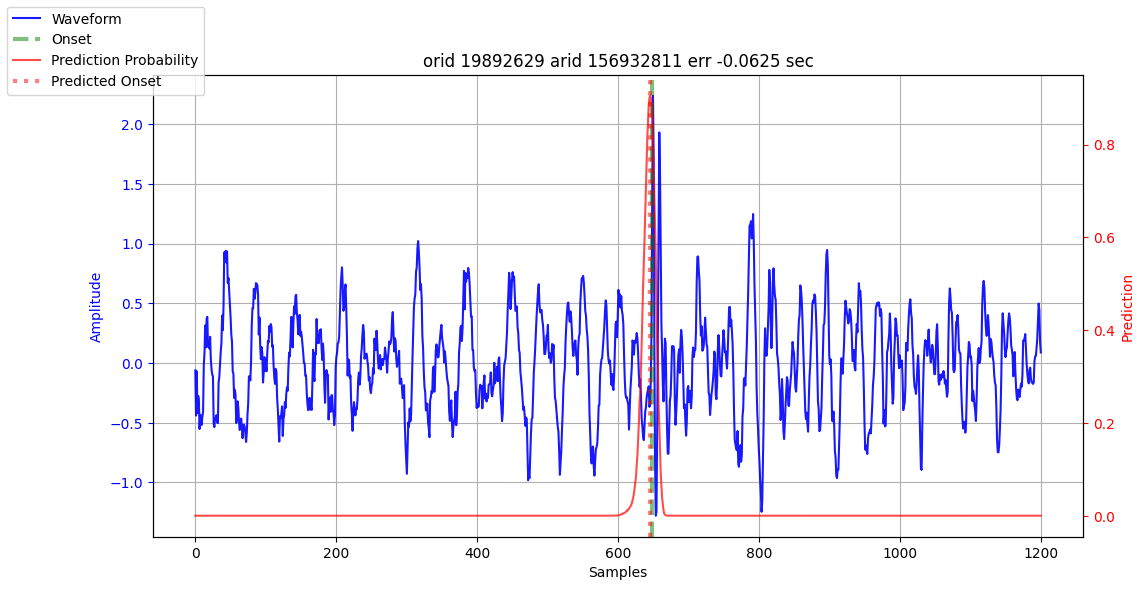

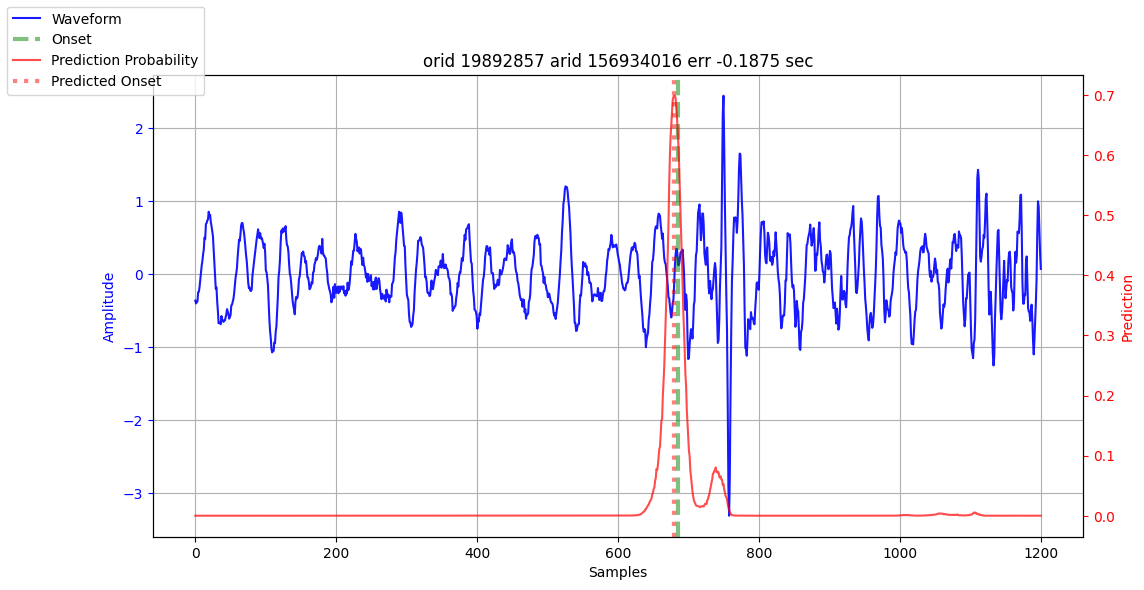

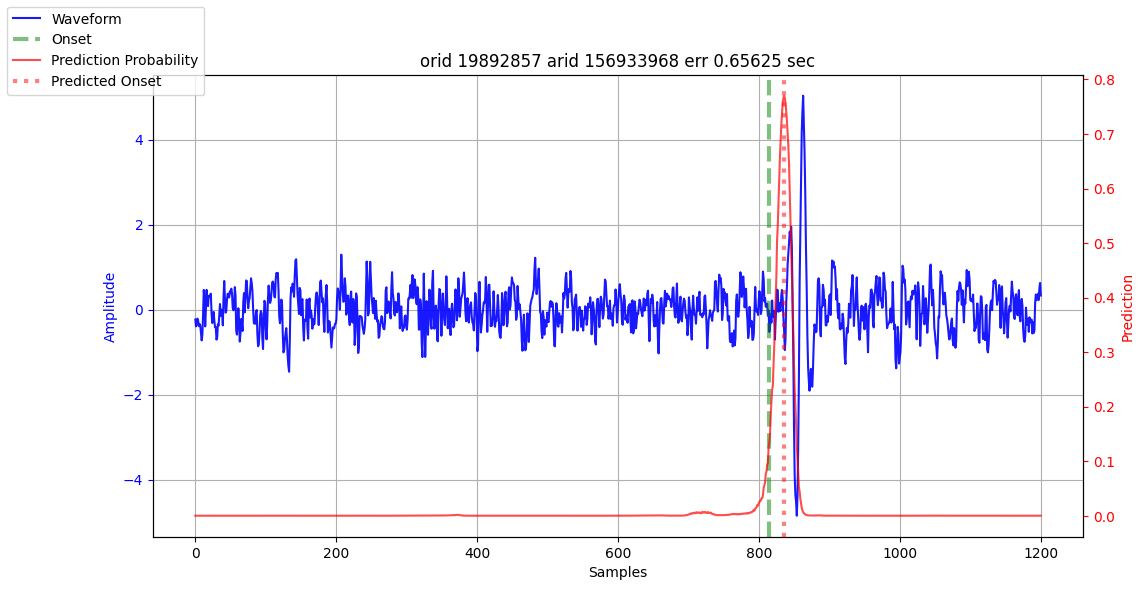

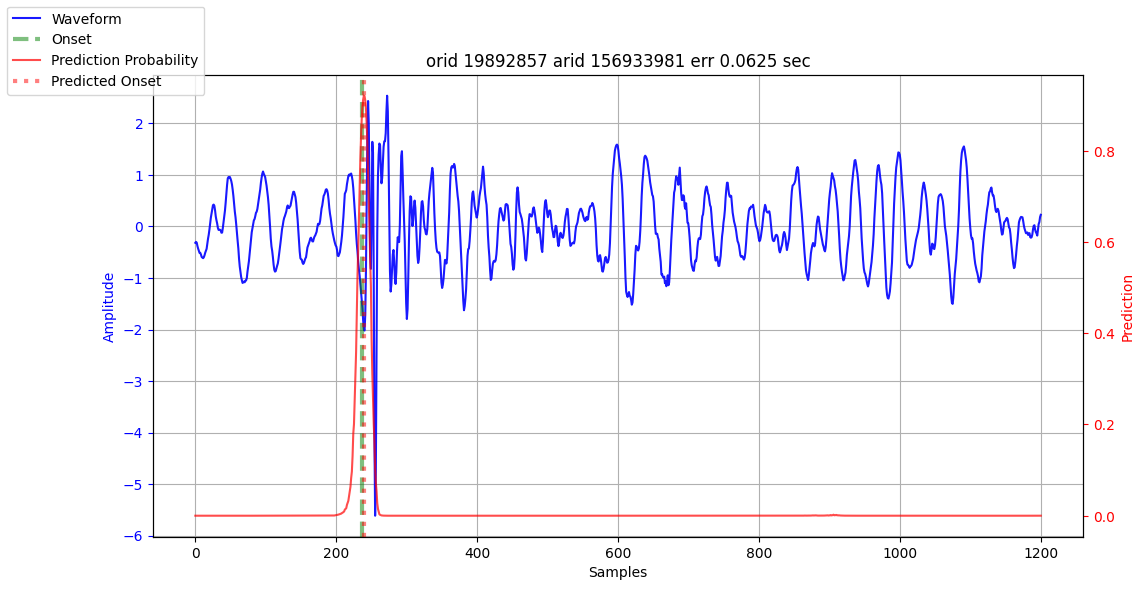

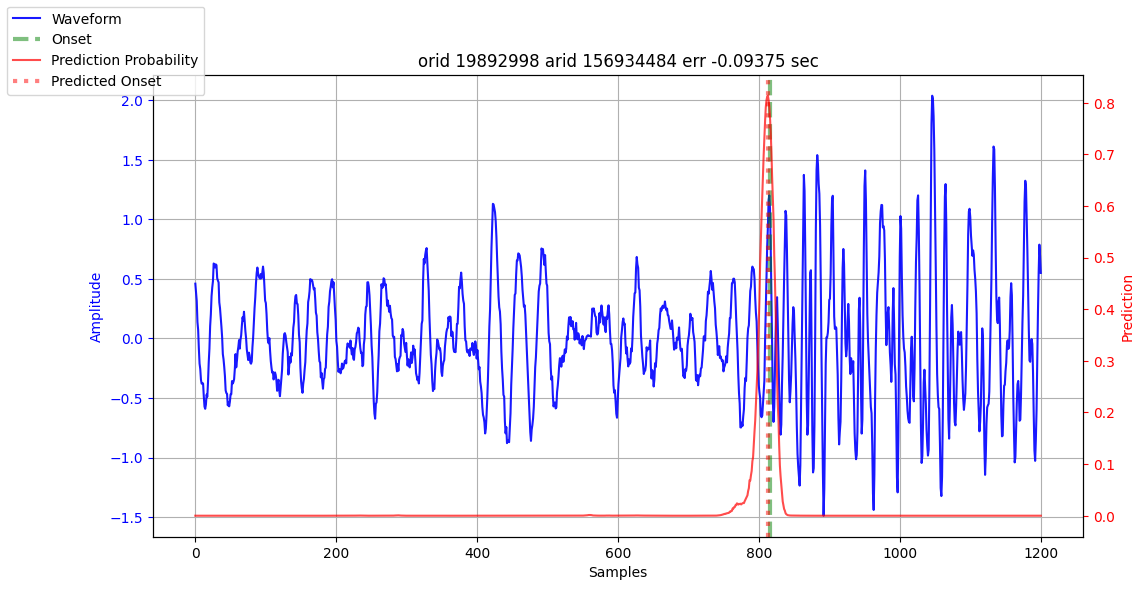

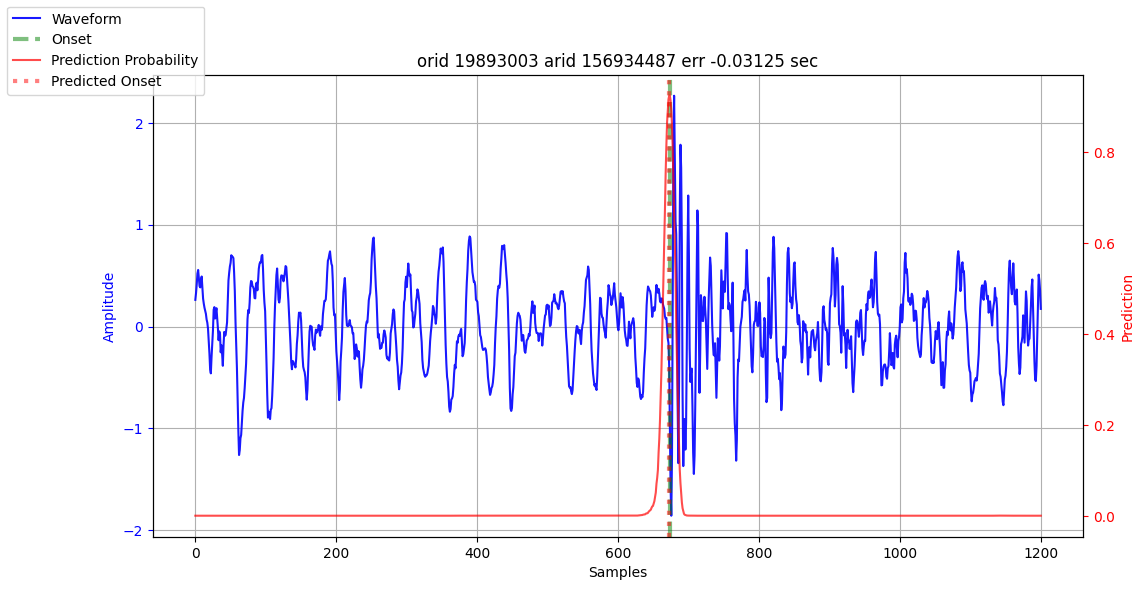

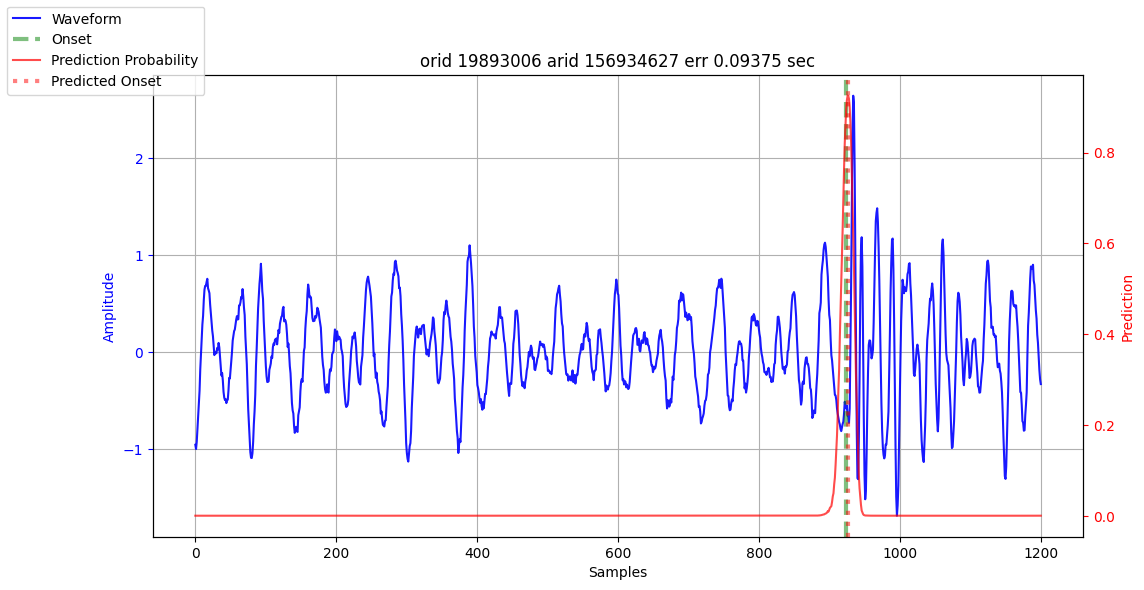

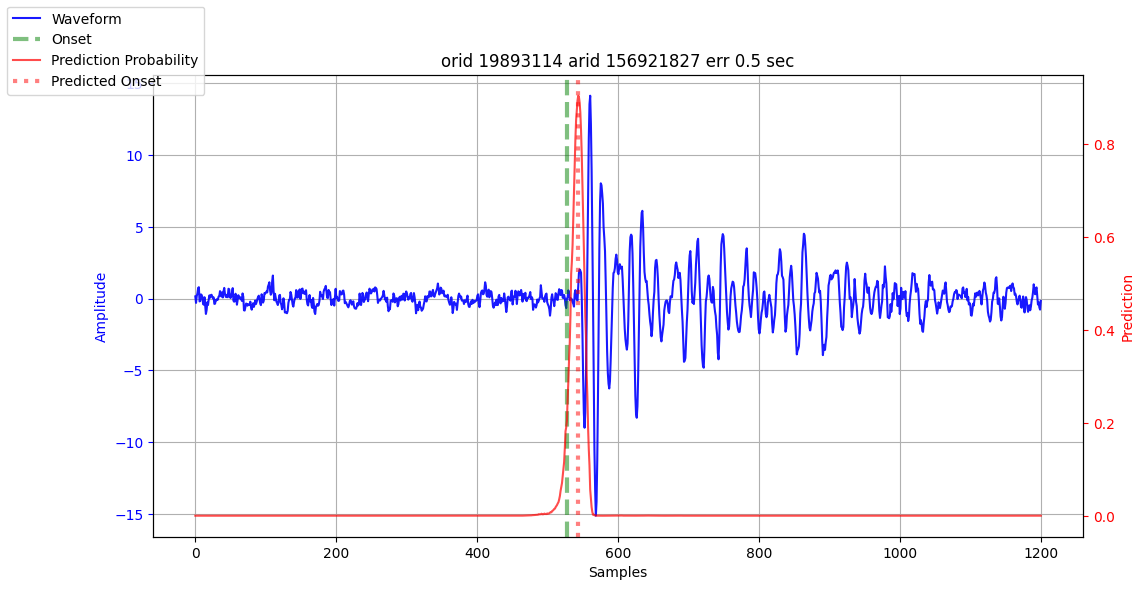

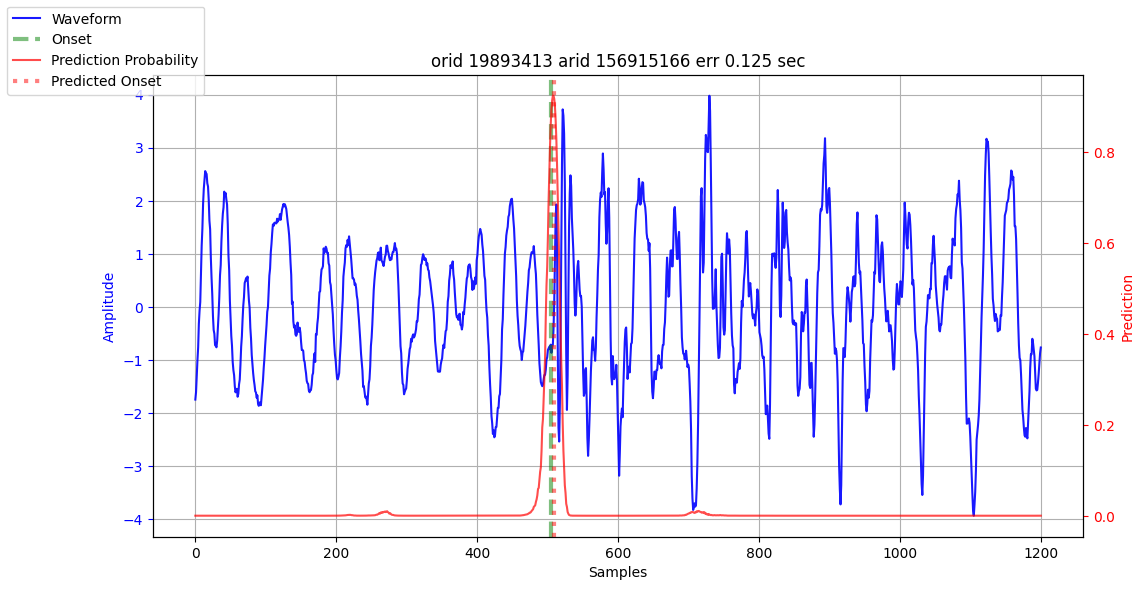

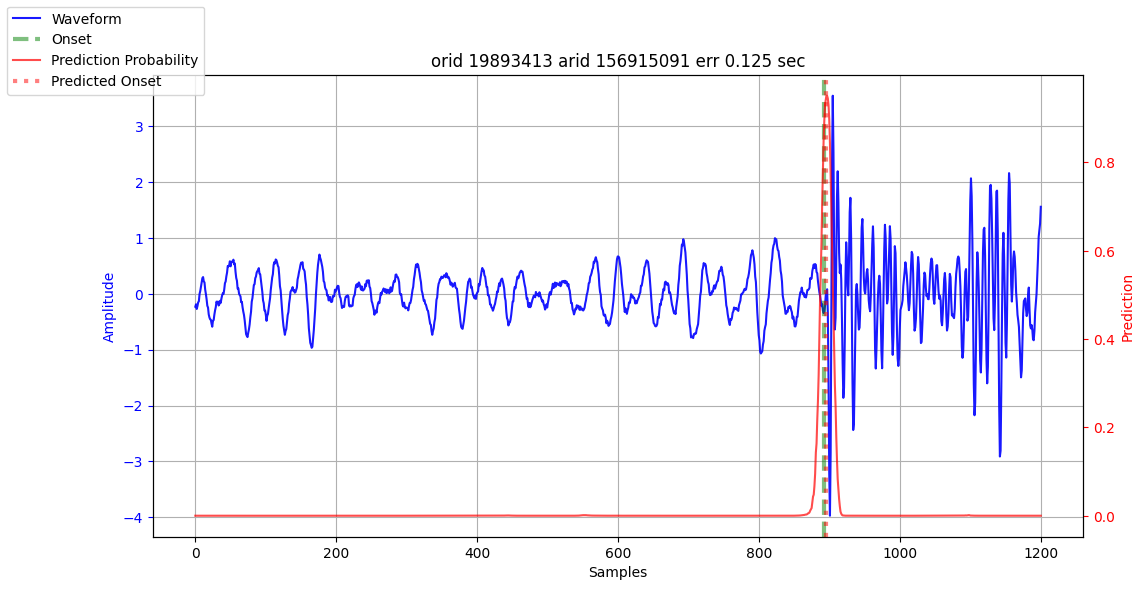

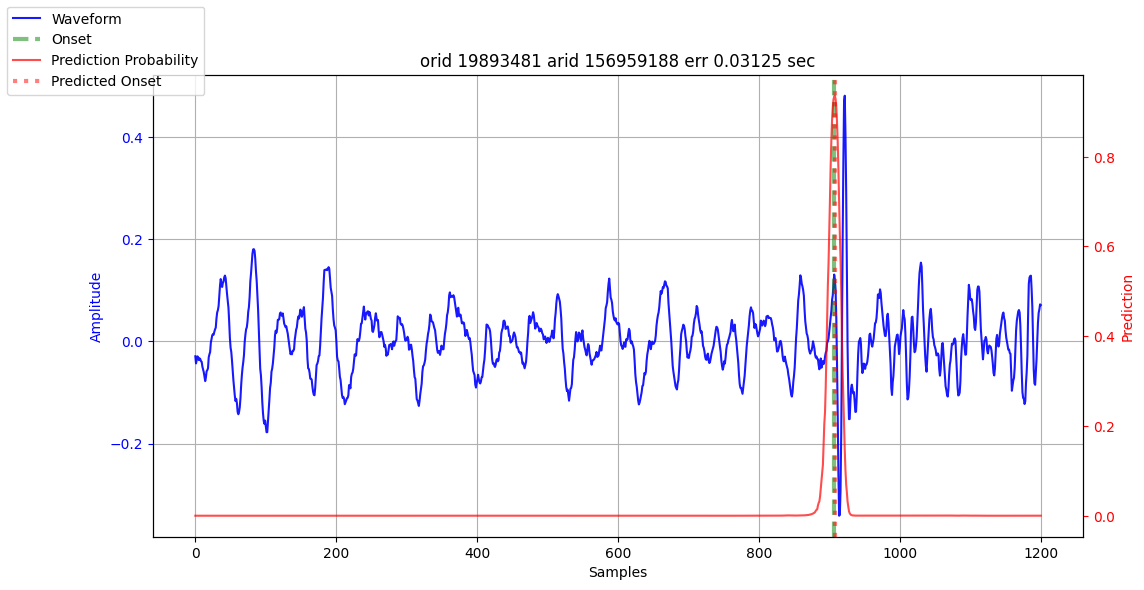

In [15]:
import matplotlib.pyplot as plt
import numpy as np

for idx in range(len(bat['waveform'])):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    data = bat['waveform'][idx].cpu().numpy()
    target = bat["target"][idx].cpu().numpy()

    err = ((out["onset_pred"][idx] - bat["onset"][idx]) / CONFIG["train"]["batch_size"]).item()

    # Plot the waveform using Matplotlib
    ax1.plot(np.arange(len(data)), data, color='blue', label='Waveform', alpha=0.9)
    ax1.set_xlabel('Samples')
    ax1.set_ylabel('Amplitude', color='blue')
    ax1.tick_params('y', colors='blue')

    # Add the target and prediction on a second y-axis
    ax2 = ax1.twinx()
    #ax2.plot(np.arange(len(data)), target, color='red', label='Target', alpha=.7)
    ax2.plot(np.arange(len(data)), out["target_pred"][idx], color='red', label='Prediction Probability', alpha=.7)
    ax2.axvline(x=out["onset_pred"][idx], color='red', linestyle=':', linewidth=3, label='Predicted Onset', alpha=.5)
    ax2.set_ylabel('Prediction', color='red')
    ax2.tick_params('y', colors='red')

    # Add a vertical line at the onset
    ax1.axvline(x=bat["onset"][idx], color='green', linestyle='--', linewidth=3, label='Onset', alpha=.5)

    # Add gridlines to the x-axis
    ax1.grid(True)

    # Set the title
    orid, arid = bat["name"][idx].split("_")
    plt.title(f"orid {orid} arid {arid} err {err} sec")

    # Display the legend
    fig.legend(loc="upper left")

    # Show the plot
    plt.show()


In [16]:
# @title Plot the examples using Plotly
import plotly.graph_objects as go
import numpy as np

for idx in range(len(bat['waveform'])):
    fig = go.Figure()

    data = bat['waveform'][idx].cpu().numpy()
    target = bat["target"][idx].cpu().numpy()

    # Plot the data using Plotly
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, mode='lines', name='Waveform', line_color="blue"))

    # Add the left y-axis for waveform
    fig.update_layout(yaxis=dict(title='Amplitude', side='left', showgrid=True))

    # Add the right y-axis for target and prediction with a title
    #fig.add_trace(go.Scatter(x=np.arange(len(data)), y=target, mode='lines', name='Target', line_color="red", yaxis='y2'))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=out["target_pred"][idx], mode='lines', name='Prediction Probability', line_color="red", yaxis='y2'))
    fig.update_layout(yaxis2=dict(title='Prediction', overlaying='y', side='right', showgrid=False))

    err = ((out["onset_pred"][idx] - bat["onset"][idx]) / CONFIG["train"]["batch_size"]).item()
    orid, arid = bat["name"][idx].split("_")
    title = f"orid {orid} arid {arid} err {err} sec"

    # Set layout
    fig.update_layout(title=title,
                      xaxis_title='Samples',
                      xaxis=dict(showgrid=True))

    fig.add_vline(x=bat["onset"][idx], line_width=3, line_dash="dashdot", line_color="green", opacity=.8)
    fig.add_vline(x=out["onset_pred"][idx], line_width=3, line_dash="dot", line_color="red", opacity=.8)

    # Show the figure
    fig.show()


# Exit the notebook

In [ ]:
if DEBUG_RUN:
    raise ValueError("stop here")
from google.colab import runtime
runtime.unassign()